# Global grids of gravity, topography, and geoid height

These datasets are co-located global grids of absolute gravity (gravitational + centrifugal component), ETOPO1 "ice-surface" topography, and geoid height at 10 arc-minute resolution. This notebook loads the grids from their text files, sets proper CF-compliant metadata, and saves them to compressed netCDF for a smaller file size (**requires** the `netcdf4` library for loading). Coordinates and geoid heights are referenced to WGS84 while topography is defined as "height above mean sea level" (which we will consider to be the geoid).

**License:** CC-BY

**Original source:** Calculated from the [EIGEN-6C4 model](https://doi.org/10.5880/icgem.2015.1) (licensed CC-BY) using the [ICGEM calculation service](http://icgem.gfz-potsdam.de/home)

In [1]:
import lzma
import os
import xarray as xr
import numpy as np
import pygmt
import harmonica as hm
import pooch

## Load the grids

Read all the grids from the text files and into xarray datasets. Save the loaded text metadada for later.

### Geoid

In [2]:
with lzma.open("EIGEN-6C4_geoid.gdf.xz", "rt") as f:
    geoid_dataset = hm.load_icgem_gdf(f, dtype="float32")
geoid_icgem_metadata = geoid_dataset.attrs.copy()
geoid = geoid_dataset.geoid
geoid

<xarray.DataArray 'geoid' (latitude: 1081, longitude: 2161)>
array([[-29.497599, -29.497599, -29.497599, ..., -29.497599, -29.497599,
        -29.497599],
       [-29.548712, -29.548435, -29.548159, ..., -29.549261, -29.548986,
        -29.548712],
       [-29.64522 , -29.644733, -29.644245, ..., -29.646185, -29.645702,
        -29.64522 ],
       ...,
       [ 14.706275,  14.7046  ,  14.70293 , ...,  14.709636,  14.707953,
         14.706275],
       [ 15.203397,  15.202868,  15.202341, ...,  15.204455,  15.203925,
         15.203397],
       [ 15.423886,  15.423886,  15.423886, ...,  15.423886,  15.423886,
         15.423886]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float32 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0

### Gravity

In [3]:
with lzma.open("EIGEN-6C4_gravity.gdf.xz", "rt") as f:
    gravity_dataset = hm.load_icgem_gdf(f, dtype="float32")
gravity_icgem_metadata = gravity_dataset.attrs.copy()
gravity_dataset

<xarray.Dataset>
Dimensions:          (latitude: 1081, longitude: 2161)
Coordinates:
  * longitude        (longitude) float32 -180.0 -179.8 -179.7 ... 179.8 180.0
  * latitude         (latitude) float32 -90.0 -89.83 -89.67 ... 89.67 89.83 90.0
Data variables:
    gravity_ell      (latitude, longitude) float32 9.801e+05 ... 9.802e+05
    height_over_ell  (latitude, longitude) float64 1e+04 1e+04 ... 1e+04 1e+04
Attributes: (12/33)
    generating_institute:  gfz-potsdam
    generating_date:       2021/06/11
    product_type:          gravity_field
    body:                  earth
    modelname:             EIGEN-6C4
    max_used_degree:       720
    ...                    ...
    maxvalue:              9.8020189E+05 mgal
    minvalue:              9.7474860E+05 mgal
    signal_wrms:           1.5468191E+03 mgal
    grid_format:           long_lat_value
    attributes:            longitude latitude gravity_ell
    attributes_units:      deg. deg. mgal

### Topography

In [4]:
with lzma.open("etopo1.gdf.xz", "rt") as f:
    topo_dataset = hm.load_icgem_gdf(f, dtype="float32")
topo_icgem_metadata = topo_dataset.attrs.copy()
topo = topo_dataset.topography_shm.rename("topography")
topo

<xarray.DataArray 'topography' (latitude: 1081, longitude: 2161)>
array([[ 2741.967 ,  2741.967 ,  2741.967 , ...,  2741.967 ,  2741.967 ,
         2741.967 ],
       [ 2768.2942,  2768.1946,  2768.095 , ...,  2768.493 ,  2768.3936,
         2768.2942],
       [ 2821.9172,  2821.685 ,  2821.4526, ...,  2822.3804,  2822.149 ,
         2821.9172],
       ...,
       [-4243.443 , -4244.1055, -4244.761 , ..., -4242.097 , -4242.7734,
        -4243.443 ],
       [-4156.4565, -4156.5615, -4156.666 , ..., -4156.246 , -4156.3516,
        -4156.4565],
       [-4236.9985, -4236.9985, -4236.9985, ..., -4236.9985, -4236.9985,
        -4236.9985]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float32 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0

## Set height as a coordinate of the gravity grid

Height is not added as a coordinate in the loaded dataset but as a variable. Add it as a 2D coordinate so we can keep this as a `DataArray`.

In [5]:
gravity = xr.DataArray(
    gravity_dataset.gravity_ell,
    coords={
        "longitude": gravity_dataset.longitude,
        "latitude": gravity_dataset.latitude,
        "height": gravity_dataset.height_over_ell.astype("float32"),
    },
    dims=("latitude", "longitude"),
    name="gravity",
)
gravity

<xarray.DataArray 'gravity' (latitude: 1081, longitude: 2161)>
array([[980106.56, 980106.56, 980106.56, ..., 980106.56, 980106.56,
        980106.56],
       [980108.2 , 980108.2 , 980108.2 , ..., 980108.2 , 980108.2 ,
        980108.2 ],
       [980108.8 , 980108.8 , 980108.8 , ..., 980108.75, 980108.75,
        980108.8 ],
       ...,
       [980153.8 , 980153.7 , 980153.6 , ..., 980153.94, 980153.9 ,
        980153.8 ],
       [980160.44, 980160.4 , 980160.4 , ..., 980160.44, 980160.44,
        980160.44],
       [980157.56, 980157.56, 980157.56, ..., 980157.56, 980157.56,
        980157.56]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float32 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0
    height     (latitude, longitude) float32 1e+04 1e+04 1e+04 ... 1e+04 1e+04

## Fix grid coordinates

Coordinates are slightly imprecise since ICGEM uses something like `np.arange` to generate them instead of `np.linspace`, which is more precise and the correct way to do it. This means that the spacing is not exactly constant, which can mess up plotting with PyGMT later on. Fix this by assigning adjusted coordinates. This shouldn't make a difference quantitatively since changes are in the order of 1e-5 or below.

In [6]:
def fix_coordinates(grid):
    """
    Replace coordinates with ones generated with np.linspace.
    """
    longitude = np.linspace(-180, 180, grid.longitude.size)
    latitude = np.linspace(-90, 90, grid.latitude.size)
    return grid.assign_coords(longitude=longitude, latitude=latitude)

In [7]:
geoid = fix_coordinates(geoid)
gravity = fix_coordinates(gravity)
topo = fix_coordinates(topo)
geoid

<xarray.DataArray 'geoid' (latitude: 1081, longitude: 2161)>
array([[-29.497599, -29.497599, -29.497599, ..., -29.497599, -29.497599,
        -29.497599],
       [-29.548712, -29.548435, -29.548159, ..., -29.549261, -29.548986,
        -29.548712],
       [-29.64522 , -29.644733, -29.644245, ..., -29.646185, -29.645702,
        -29.64522 ],
       ...,
       [ 14.706275,  14.7046  ,  14.70293 , ...,  14.709636,  14.707953,
         14.706275],
       [ 15.203397,  15.202868,  15.202341, ...,  15.204455,  15.203925,
         15.203397],
       [ 15.423886,  15.423886,  15.423886, ...,  15.423886,  15.423886,
         15.423886]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float64 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0

## Set proper metadata

Add proper metadata following CF-conventions to all `DataArrays` and the `Dataset` as a whole.

In [8]:
def minmax_round(grid, decimals):
    """
    Return the minimum and maximum values in the grid 
    rounded to *decimal* places.
    """
    vmin = np.round(grid.values.min(), decimals=decimals)
    vmax = np.round(grid.values.max(), decimals=decimals)
    return (vmin, vmax)

### Geoid

In [9]:
geoid.attrs = {
    "Conventions": "CF-1.8",
    "title": "Geoid height (EIGEN-6C4) with respect to WGS84",
    "crs": "WGS84",
    "source": "Generated from the EIGEN-6C4 model by the ICGEM Calculation Service (http://icgem.gfz-potsdam.de)",
    "license": "Creative Commons Attribution 4.0 International Licence",
    "references": "https://doi.org/10.5880/icgem.2015.1",
    "long_name": "geoid height",
    "standard_name": "geoid_height_above_reference_ellipsoid",
    "description": "height of the geoid with respect to the WGS84 ellipsoid",
    "units": "m",
    "actual_range": minmax_round(geoid, decimals=1),
    "icgem_metadata": "\n".join([f"{k}: {v}" for k,v in geoid_icgem_metadata.items()]),
}
geoid.longitude.attrs = {
    "long_name": "longitude",
    "standard_name": "longitude",
    "units": "degrees_east",
    "actual_range": (geoid.longitude.values.min(), geoid.longitude.values.max()),
}
geoid.latitude.attrs = {
    "long_name": "latitude",
    "standard_name": "latitude",
    "units": "degrees_north",
    "actual_range": (geoid.latitude.values.min(), geoid.latitude.values.max()),
}
geoid

<xarray.DataArray 'geoid' (latitude: 1081, longitude: 2161)>
array([[-29.497599, -29.497599, -29.497599, ..., -29.497599, -29.497599,
        -29.497599],
       [-29.548712, -29.548435, -29.548159, ..., -29.549261, -29.548986,
        -29.548712],
       [-29.64522 , -29.644733, -29.644245, ..., -29.646185, -29.645702,
        -29.64522 ],
       ...,
       [ 14.706275,  14.7046  ,  14.70293 , ...,  14.709636,  14.707953,
         14.706275],
       [ 15.203397,  15.202868,  15.202341, ...,  15.204455,  15.203925,
         15.203397],
       [ 15.423886,  15.423886,  15.423886, ...,  15.423886,  15.423886,
         15.423886]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float64 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0
Attributes:
    Conventions:     CF-1.8
    title:           Geoid height (EIGEN-6C4) with respect to WGS84
    crs:             WGS84
    source:          Generated from the EIGEN-6C4 model by the ICGEM Calculat...
    license:         Creative Commons Attribution 4.0 International Licence
    references:      https://doi.org/10.5880/icgem.2015.1
    long_name:       geoid height
    standard_name:   geoid_height_above_reference_ellipsoid
    description:     height of the geoid with respect to the WGS84 ellipsoid
    units:           m
    actual_range:    (-106.5, 86.0)
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

### Gravity

In [10]:
gravity.attrs = {
    "Conventions": "CF-1.8",
    "title": "Gravity acceleration (EIGEN-6C4) at a constant geometric height",
    "crs": "WGS84",
    "source": "Generated from the EIGEN-6C4 model by the ICGEM Calculation Service (http://icgem.gfz-potsdam.de)",
    "license": "Creative Commons Attribution 4.0 International Licence",
    "references": "https://doi.org/10.5880/icgem.2015.1",
    "long_name": "gravity acceleration",
    "description": "magnitude of the gravity acceleration vector (gravitational + centrifugal)",
    "units": "mGal",
    "actual_range": minmax_round(gravity, decimals=1),
    "icgem_metadata": "\n".join([f"{k}: {v}" for k,v in gravity_icgem_metadata.items()]),
}
gravity.longitude.attrs = {
    "long_name": "longitude",
    "standard_name": "longitude",
    "units": "degrees_east",
    "actual_range": (gravity.longitude.values.min(), gravity.longitude.values.max()),
}
gravity.latitude.attrs = {
    "long_name": "latitude",
    "standard_name": "latitude",
    "units": "degrees_north",
    "actual_range": (gravity.latitude.values.min(), gravity.latitude.values.max()),
}
gravity.height.attrs = {
    "long_name": "geometric height",
    "standard_name": "height_above_reference_ellipsoid",
    "description": "height of gravity computation points above the WGS84 ellipsoid",
    "units": "m",
    "actual_range": (gravity.height.values.min(), gravity.height.values.max()),
}
gravity

<xarray.DataArray 'gravity' (latitude: 1081, longitude: 2161)>
array([[980106.56, 980106.56, 980106.56, ..., 980106.56, 980106.56,
        980106.56],
       [980108.2 , 980108.2 , 980108.2 , ..., 980108.2 , 980108.2 ,
        980108.2 ],
       [980108.8 , 980108.8 , 980108.8 , ..., 980108.75, 980108.75,
        980108.8 ],
       ...,
       [980153.8 , 980153.7 , 980153.6 , ..., 980153.94, 980153.9 ,
        980153.8 ],
       [980160.44, 980160.4 , 980160.4 , ..., 980160.44, 980160.44,
        980160.44],
       [980157.56, 980157.56, 980157.56, ..., 980157.56, 980157.56,
        980157.56]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float64 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0
    height     (latitude, longitude) float32 1e+04 1e+04 1e+04 ... 1e+04 1e+04
Attributes:
    Conventions:     CF-1.8
    title:           Gravity acceleration (EIGEN-6C4) at a constant geometric...
    crs:             WGS84
    source:          Generated from the EIGEN-6C4 model by the ICGEM Calculat...
    license:         Creative Commons Attribution 4.0 International Licence
    references:      https://doi.org/10.5880/icgem.2015.1
    long_name:       gravity acceleration
    description:     magnitude of the gravity acceleration vector (gravitatio...
    units:           mGal
    actual_range:    (974748.6, 980201.9)
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

### Topography

In [11]:
topo.attrs = {
    "Conventions": "CF-1.8",
    "title": "Topographic and bathymetric height of ETOPO1 (ice surface) at 10 arc-minute resolution",
    "crs": "WGS84",
    "source": "Generated from a spherical harmonic model by the ICGEM Calculation Service (http://icgem.gfz-potsdam.de)",
    "license": "public domain",
    "references": "https://doi.org/10.7289/V5C8276M",
    "long_name": "topographic height above mean sea level",
    "standard_name": "height_above_mean_sea_level",
    "description": "height topography/bathymetry referenced to mean sea level",
    "units": "m",
    "actual_range": minmax_round(topo, decimals=0),
    "icgem_metadata": "\n".join([f"{k}: {v}" for k,v in topo_icgem_metadata.items()]),
}
topo.longitude.attrs = {
    "long_name": "longitude",
    "standard_name": "longitude",
    "units": "degrees_east",
    "actual_range": (topo.longitude.values.min(), topo.longitude.values.max()),
}
topo.latitude.attrs = {
    "long_name": "latitude",
    "standard_name": "latitude",
    "units": "degrees_north",
    "actual_range": (topo.latitude.values.min(), topo.latitude.values.max()),
}
topo

<xarray.DataArray 'topography' (latitude: 1081, longitude: 2161)>
array([[ 2741.967 ,  2741.967 ,  2741.967 , ...,  2741.967 ,  2741.967 ,
         2741.967 ],
       [ 2768.2942,  2768.1946,  2768.095 , ...,  2768.493 ,  2768.3936,
         2768.2942],
       [ 2821.9172,  2821.685 ,  2821.4526, ...,  2822.3804,  2822.149 ,
         2821.9172],
       ...,
       [-4243.443 , -4244.1055, -4244.761 , ..., -4242.097 , -4242.7734,
        -4243.443 ],
       [-4156.4565, -4156.5615, -4156.666 , ..., -4156.246 , -4156.3516,
        -4156.4565],
       [-4236.9985, -4236.9985, -4236.9985, ..., -4236.9985, -4236.9985,
        -4236.9985]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float64 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0
Attributes:
    Conventions:     CF-1.8
    title:           Topographic and bathymetric height of ETOPO1 (ice surfac...
    crs:             WGS84
    source:          Generated from a spherical harmonic model by the ICGEM C...
    license:         public domain
    references:      https://doi.org/10.7289/V5C8276M
    long_name:       topographic height above mean sea level
    standard_name:   height_above_mean_sea_level
    description:     height topography/bathymetry referenced to mean sea level
    units:           m
    actual_range:    (-10023.0, 6082.0)
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

## Save to netCDF

Save all grids to separate netCDF files (so they can be downloaded independently if needed). 

In [12]:
def print_info(fname):
    """
    Print the file size and checksums.
    Also loads back the grid, plots it, and returns the DataArray for inspection.
    """
    print(fname)
    for alg in ["md5", "sha256"]:
        print(f"  {alg}:{pooch.file_hash(fname, alg=alg)}")
    print(f"  size: {os.path.getsize(fname) / 1e6} Mb")    
    
    tmp = xr.load_dataarray(fname)
    # Make sure no NaNs are read back. This would indicate a problem
    # with the _FillValue.
    assert not np.any(np.isnan(tmp.data))
    
    fig = pygmt.Figure()
    fig.grdimage(tmp, cmap="polar+h", projection="W25c")
    fig.colorbar()
    fig.basemap(frame=True)
    fig.show(width=800, dpi=120)
    return tmp

Use compression (both zlib and discretization based) to reduce the file sizes. The `scale_factor` determines the amount of decimal places retained when converting floats into integers. See http://xarray.pydata.org/en/stable/user-guide/io.html#writing-encoded-data

gravity-earth-10arcmin.nc
  md5:36bc806111d63e29eee08c38bd1d6cd7
  sha256:8d6c75d0f723678b175a9ddb929aee38b155bb5dbc54052697dd1a2342699af1
  size: 2.518301 Mb


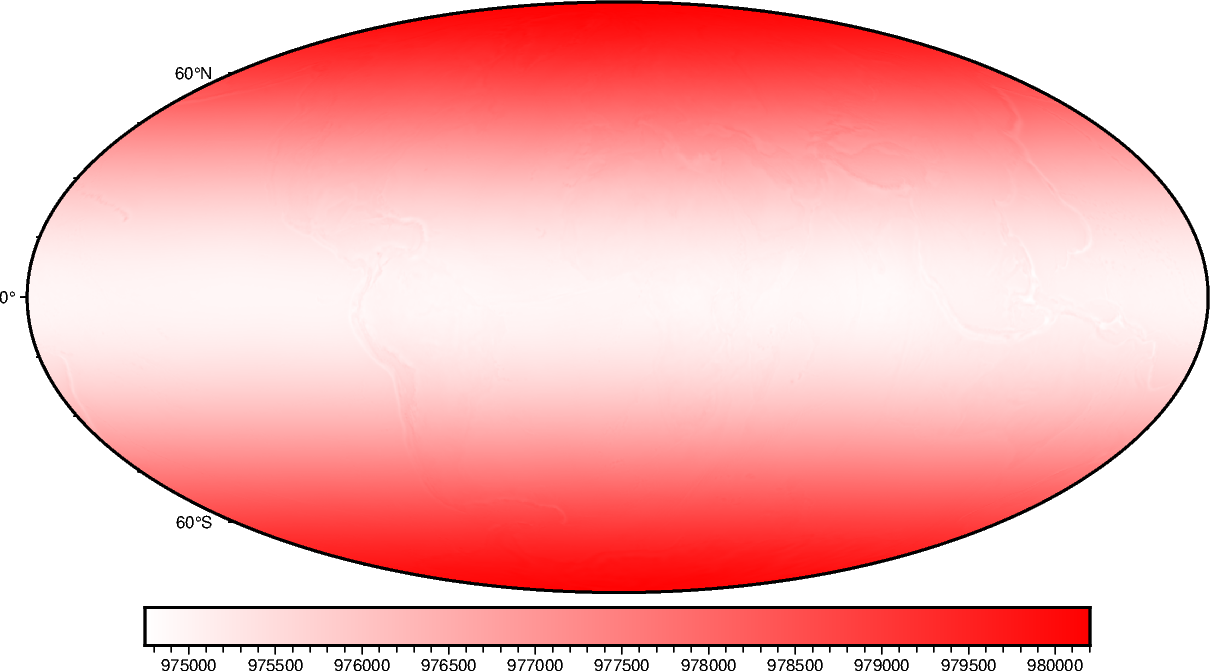

<xarray.DataArray 'gravity' (latitude: 1081, longitude: 2161)>
array([[980106.5 , 980106.5 , 980106.5 , ..., 980106.5 , 980106.5 ,
        980106.5 ],
       [980108.25, 980108.25, 980108.25, ..., 980108.25, 980108.25,
        980108.25],
       [980108.8 , 980108.8 , 980108.8 , ..., 980108.75, 980108.75,
        980108.8 ],
       ...,
       [980153.8 , 980153.75, 980153.6 , ..., 980153.94, 980153.8 ,
        980153.8 ],
       [980160.44, 980160.44, 980160.44, ..., 980160.44, 980160.44,
        980160.44],
       [980157.5 , 980157.5 , 980157.5 , ..., 980157.5 , 980157.5 ,
        980157.5 ]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float64 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0
    height     (latitude, longitude) float32 1e+04 1e+04 1e+04 ... 1e+04 1e+04
Attributes:
    Conventions:     CF-1.8
    title:           Gravity acceleration (EIGEN-6C4) at a constant geometric...
    crs:             WGS84
    source:          Generated from the EIGEN-6C4 model by the ICGEM Calculat...
    license:         Creative Commons Attribution 4.0 International Licence
    references:      https://doi.org/10.5880/icgem.2015.1
    long_name:       gravity acceleration
    description:     magnitude of the gravity acceleration vector (gravitatio...
    units:           mGal
    actual_range:    [974748.6 980201.9]
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

In [13]:
fname = "gravity-earth-10arcmin.nc"
gravity.to_netcdf(
    fname, 
    format="NETCDF4",
    encoding={
        'gravity': {
            "zlib": True, 
            'dtype': 'uint16', 
            'scale_factor': 0.1, 
            '_FillValue': 65000, 
            'add_offset': np.round(gravity.values.min(), decimals=1),
        },
        'height': {
            "zlib": True, 
        },
    }
)
print_info(fname)

geoid-earth-10arcmin.nc
  md5:76117ceca7f31fe17122278370996303
  sha256:9c4d1676c11d1321b53fb14a1df460748880936efb21ebfabc8b548f2551dfbb
  size: 1.33967 Mb


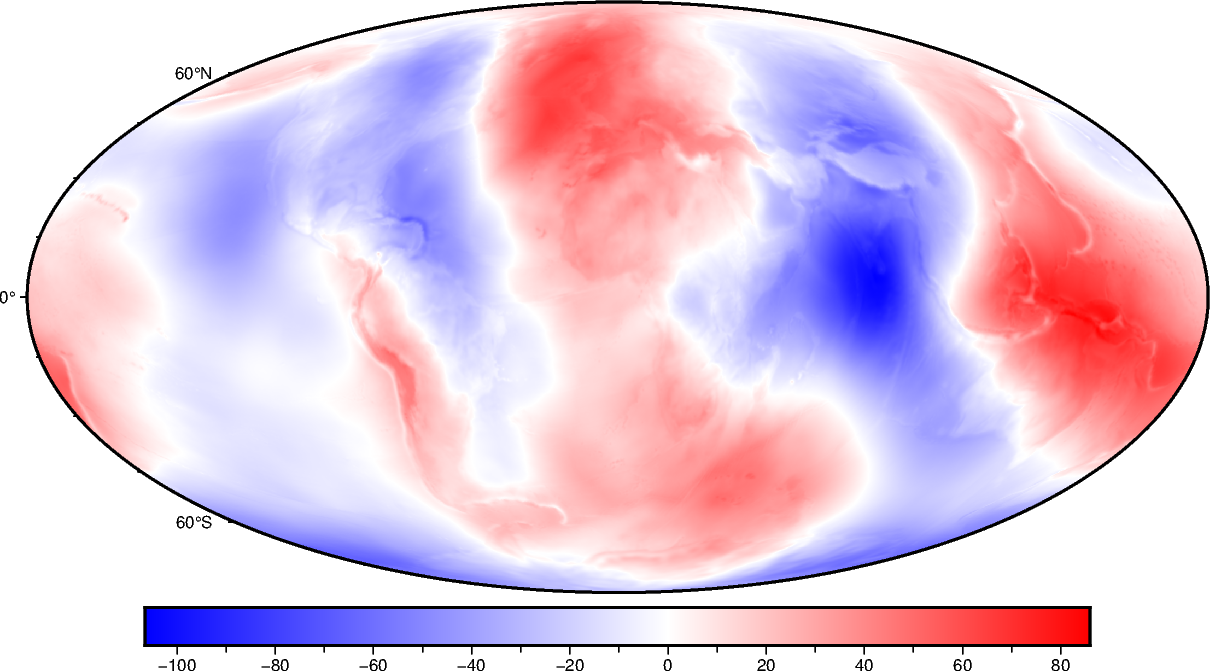

<xarray.DataArray 'geoid' (latitude: 1081, longitude: 2161)>
array([[-29.5     , -29.5     , -29.5     , ..., -29.5     , -29.5     ,
        -29.5     ],
       [-29.5     , -29.5     , -29.5     , ..., -29.5     , -29.5     ,
        -29.5     ],
       [-29.6     , -29.6     , -29.6     , ..., -29.6     , -29.6     ,
        -29.6     ],
       ...,
       [ 14.7     ,  14.7     ,  14.7     , ...,  14.7     ,  14.7     ,
         14.7     ],
       [ 15.2     ,  15.2     ,  15.2     , ...,  15.2     ,  15.2     ,
         15.2     ],
       [ 15.400001,  15.400001,  15.400001, ...,  15.400001,  15.400001,
         15.400001]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float64 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0
Attributes:
    Conventions:     CF-1.8
    title:           Geoid height (EIGEN-6C4) with respect to WGS84
    crs:             WGS84
    source:          Generated from the EIGEN-6C4 model by the ICGEM Calculat...
    license:         Creative Commons Attribution 4.0 International Licence
    references:      https://doi.org/10.5880/icgem.2015.1
    long_name:       geoid height
    standard_name:   geoid_height_above_reference_ellipsoid
    description:     height of the geoid with respect to the WGS84 ellipsoid
    units:           m
    actual_range:    [-106.5   86. ]
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

In [14]:
fname = "geoid-earth-10arcmin.nc"
geoid.to_netcdf(
    fname, 
    format="NETCDF4",
    encoding={
        'geoid': {
            "zlib": True, 
            'dtype': 'int16', 
            'scale_factor': 0.1, 
            '_FillValue': 32000, 
            'add_offset': 0,
        },
    }
)
print_info(fname)

topography-earth-10arcmin.nc
  md5:c0c8d1fad9f7046c878d65cfc9d1dc8c
  sha256:046846c21426bd6da0fdf63077dd69b8ef11639017bdc9bf1bf4d5fc75c9b093
  size: 2.746129 Mb


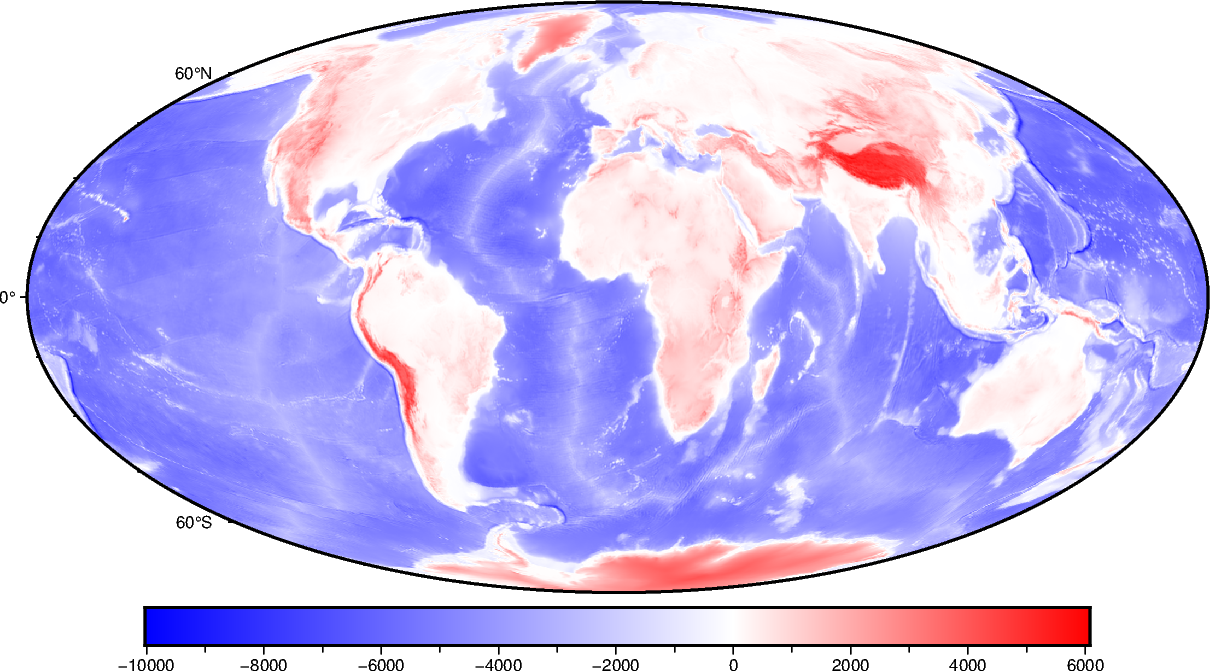

<xarray.DataArray 'topography' (latitude: 1081, longitude: 2161)>
array([[ 2742.,  2742.,  2742., ...,  2742.,  2742.,  2742.],
       [ 2768.,  2768.,  2768., ...,  2768.,  2768.,  2768.],
       [ 2822.,  2822.,  2821., ...,  2822.,  2822.,  2822.],
       ...,
       [-4243., -4244., -4245., ..., -4242., -4243., -4243.],
       [-4156., -4157., -4157., ..., -4156., -4156., -4156.],
       [-4237., -4237., -4237., ..., -4237., -4237., -4237.]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float64 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0
Attributes:
    Conventions:     CF-1.8
    title:           Topographic and bathymetric height of ETOPO1 (ice surfac...
    crs:             WGS84
    source:          Generated from a spherical harmonic model by the ICGEM C...
    license:         public domain
    references:      https://doi.org/10.7289/V5C8276M
    long_name:       topographic height above mean sea level
    standard_name:   height_above_mean_sea_level
    description:     height topography/bathymetry referenced to mean sea level
    units:           m
    actual_range:    [-10023.   6082.]
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

In [15]:
fname = "topography-earth-10arcmin.nc"
topo.to_netcdf(
    fname, 
    format="NETCDF4",
    encoding={
        'topography': {
            "zlib": True, 
            'dtype': 'int16', 
            'scale_factor': 1.0, 
            '_FillValue': 32000, 
            'add_offset': 0,
        },
    }
)
print_info(fname)